In [1]:
#pip install openeo[localprocessing]

In [12]:
import geopandas as gpd
import os 
import matplotlib.pyplot as plt

from openeo.processes import and_, is_nan, is_valid, not_, is_nodata, or_
from openeo.local import LocalConnection

from pathlib import Path
import json
import openeo
from shapely.geometry import shape


from utils import extent_from_shp, get_scf_ranges, upsample

import leafmap.foliumap as leafmap
import xarray as xr
from openeo.udf import execute_local_udf
from openeo.rest.auth.config import RefreshTokenStore


## Authentication
- to the Copernicus Data Space Ecosystem https://openeo.dataspace.copernicus.eu/
- Vito backend https://openeo-dev.vito.be

In [30]:
eoconn = openeo.connect("https://openeo-dev.vito.be")
eoconn.authenticate_oidc()

eoconn.describe_account()

Authenticated using refresh token.


{'info': {'oidc_userinfo': {'eduperson_assurance': ['https://refeds.org/assurance/IAP/low',
    'https://aai.egi.eu/LoA#Substantial'],
   'eduperson_entitlement': ['urn:mace:egi.eu:group:vo.openeo.cloud:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=vm_operator#aai.egi.eu'],
   'eduperson_scoped_affiliation': ['employee@eurac.edu', 'member@eurac.edu'],
   'email': 'valentina.premier@eurac.edu',
   'email_verified': True,
   'sub': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu',
   'voperson_verified_email': ['Valentina.Premier@eurac.edu']}},
 'name': 'Valentina.Premier@eurac.edu',
 'user_id': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu'}

In [22]:
#RefreshTokenStore().remove()

## Show the study area and get the bounding box
- Read a shapefile with the AOI
- Get the basin outline
- Show on the map

In [31]:
shp_path = r'/mnt/CEPH_PROJECTS/PROSNOW/research_activity/Senales/auxiliary/boundaries/SenalesCatchment/SenalesCatchment.shp'

catchment_outline = gpd.read_file(shp_path)
bbox = catchment_outline.bounds.iloc[0]

center = (float(catchment_outline.centroid.y), 
          float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=1)
m.add_vector(shp_path, layer_name="catchment")


## Load the Copernicus fractional snow cover collection

In [32]:
eps= 0.05 # buffer of ca. 500 m
scf = eoconn.load_collection(
    "FRACTIONAL_SNOW_COVER",
    spatial_extent  = {'west':bbox[0]-eps,
                       'east':bbox[2]+eps,
                       'south':bbox[1]-eps,
                       'north':bbox[3]+eps,
                       'crs':4326},
    temporal_extent=['2023-08-02','2023-08-15'],
    bands=["FSCTOC"]
)
#scf.download('./results/scf_new.nc')

We have a time series of high-resolution (HR TS) scenes acquired over a specific area. 
The scene are derived from the Copernicus fractional snow cover product for now and need to be binarized (snow-free = 0, snow = 100, no data = 205)

## Load the MODIS data from Eurac Research STAC Catalog

## <font color='red'>ISSUES: </font> 
- load_stac does not return the correct extent: opened issue https://discuss.eodc.eu/t/spatial-shift-when-loading-data-from-the-stac-catalogue/738
- resampling is not cropping on the correct extent.

In [33]:
modis =eoconn.load_stac("https://planetarycomputer.microsoft.com/api/stac/v1/collections/modis-10A1-061",
                        temporal_extent = ["2023-01-20","2023-01-21"],
                            spatial_extent  = {'west':bbox[0]-eps,
                           'east':bbox[2]+eps,
                           'south':bbox[1]-eps,
                           'north':bbox[3]+eps,
                           'crs':4326},
                           bands=["NDSI"])

# limitation in downloading, possibly in the future you can give 
# your id as key to download directly through zour accont your id as kez to download directlz through zour acconut
#modis.download('./results/modis_pc.nc')
# this is still not working: it does not find the correct metadata

In [34]:
modis = eoconn.load_stac("https://stac.eurac.edu/collections/MOD10A1v61",
                      temporal_extent = ["2023-01-20","2023-01-21"])
#modis.download('modis.nc')

In [35]:
s2_resampled = scf.resample_cube_spatial(target=modis,method="average")
#s2_resampled.download('scf_rsmp2.tiff')

## <font color='red'>WORKAROUND: </font> 

In [36]:
west=631810.
south=5167710.
east=655790.
north=5184190.
res = 20.

# check that the grid is aligned with a 500 m gri
print('Nr. of low-resolution pixels in the resampled grid (x): {}'.format((east + res/2. - (west - res/2. ))/500.))
print('Nr. of low-resolution pixels in the resampled grid (y): {}'.format((south - res/2. - (north + res/2. ))/-500.))

scf_rsmpl = scf.resample_spatial(resolution=res, 
                                 projection=32632,
                                 method = "cubic")

            
scf_bbox = scf_rsmpl.filter_bbox(west=west, 
                                 south=south, 
                                 east=east, 
                                 north=north, 
                                 crs=32632)
#scf_bbox.download(base_path + os.sep + 'scf_rsmp.nc'scf_bbox.download(base_path + os.sep + 'scf_rsmp.nc'#)
scf_bbox

Nr. of low-resolution pixels in the resampled grid (x): 48.0
Nr. of low-resolution pixels in the resampled grid (y): 33.0


The Copernicus FSC needs to be converted to a binary map: snow (100) - snow free (0) and clouds/no data (205)

In [29]:
binarize = openeo.UDF.from_file('udf-binarize.py', 
                                context={"from_parameter": "context"})


scf_binary = scf_bbox.apply(process=binarize, 
                            context={"snowT": 20})

#scf_binary_renamed = scf_binary.rename_labels(dimension="bands",target=["scf"])

scf_binary.download('scf_binary_nodata2.nc')

# More elegant alternative: band math but problem with the unsigned bits
# scf_test = 100.0 * (scf >= 20) * (scf <= 100) + 205.0 * (scf == 205)

## Downscaling
Workflow for downscaling MODIS SCF or another low-resolution (LR) dataset to Sentinel-2 resolution or analogous high-resolution (HR) dataset. We work with two different resolutions:

<div>
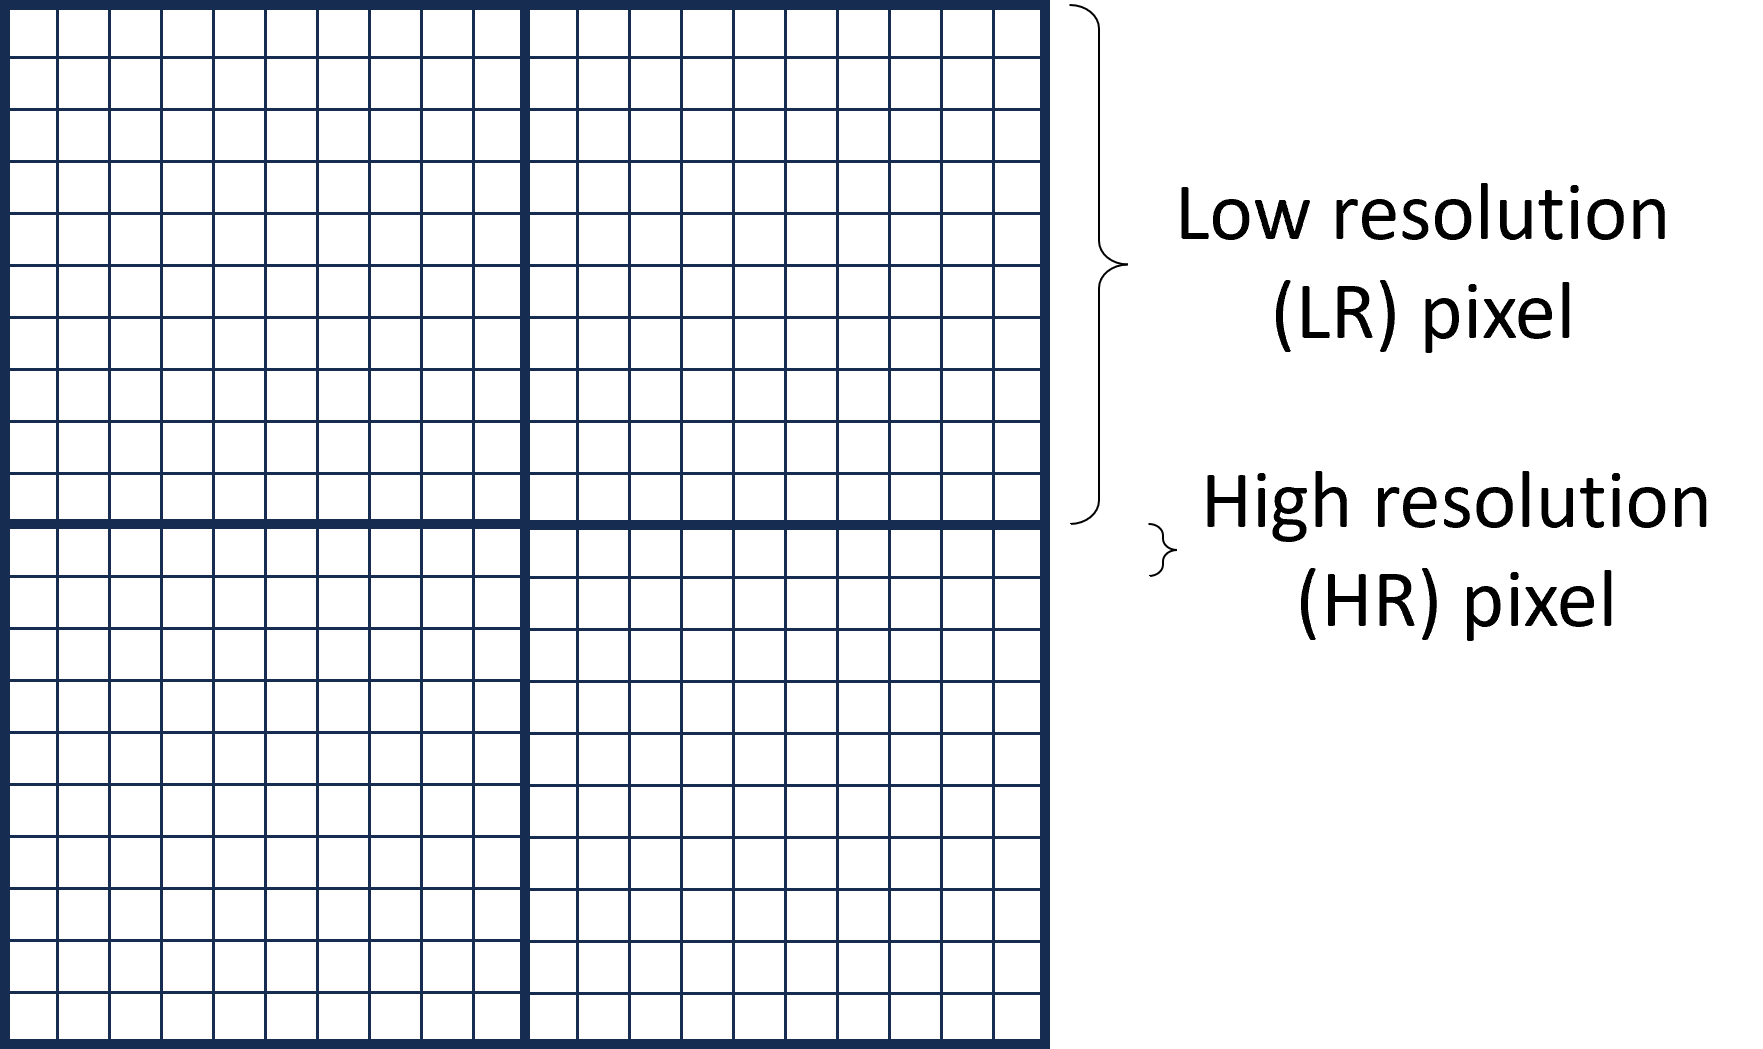
</div>

The workflow to downscale MODI SCF is shown by this figure:
<div>
<img src="attachment:downscaling.png" width="700"/>
</div>

- Applied when a LR map is available for the date to be reconstructed;
- Based on an observed/interpolated SCF;
- Conditional probability to observe a pixel as snow given the historical LR snow pattern persistence is computed as follows:

 
$$
 P_i(\omega_{s}|SCF_{HR,j}) = 
 \frac{\sum_{p=0}^{P}x_{i}^{p}}{P}, \: x_i \subset X_j
$$

Hence it follows:
$$
\begin{split}
& x_{i}=\omega_{s}, \:  \textbf{if} \: 
\begin{cases}
& P_i(\omega_{s}|SCF_{LR,j}) = 1 \\
& SCF_{LR,j} = 1
 \end{cases} , \: x_i \subset X_j\\
& x_{i}=\omega_{sf}, \:  \textbf{if} \: 
    \begin{cases}
    & P_i(\omega_{s}|SCF_{LR,j}) = 0 \\
    & SCF_{LR,j} = 0
     \end{cases} , \: x_i \subset X_j
\end{split}
$$

### Replace non valid values
## <font color='red'>ISSUES: </font> 
No way to replace no data with a value?

In [16]:
# different from nan (that is snow free)
mask_non_nv = is_nodata(scf_binary) 
# nan (that is equal to snow free) -> this workaround has to be done since fillna is not implemented
#mask_sf = mask_non_nv.apply(process='not') 

cube_renamed = scf_binary.rename_labels(dimension="bands",
                                              target=["scf"])
def mask_valid(data):
    binary = data.array_element(label = "scf")
    mask = is_nodata(binary)   

    return mask

mask = cube_renamed.apply(mask_valid)
cube = cube_renamed.mask(mask,replacement=0)
#cube.download('./results/cube_test.nc')


Define constant values to be used in the notebook.

In [17]:
# Ratio betweeen the size of a LR and a HR pixel, e.g., 500 m and 20 m.
pixel_ratio = 25 
# non-valid values
codes = [205, 210, 254, 255] 
nv_value = 205
# Threshold of non valid HR pixels allowed within a LR pixel [%]
nv_thres = 10 

# delta and epsilon: are used to define the SCF ranges. 
# The delta defines the steps, while epsilon represents a security buffer
delta = 10
epsilon = 10



### Aggregation of the HR maps and SCF computation
First, we need to aggregate our HR maps and compute a snow cover fraction (SCF) value for the target LR pixel. We need to count how many pixels are snow within a LR window.

To do that, we create the following masks:
- mask (HR) with all the valid data, i.e., values equal to 0 or 100;
- mask (HR) with all the pixels labelled as snow, i.e., equal to 100. 

Sum the number of valid and snow data within a LR pixel to get SCF.

To this purpose, a threshold on the possible non valid data is set (see constants defined above).

We also compute SCF_min, i.e., the minimum SCF that we would have if all non valid pixels are replaced with snow free. Similarly, we compute SCF_max, i.e., the maximum SCF that we would have if all non valid pixels are replaced with snow. SCF_min and SCF_max are not used here but will be used later in the workflow.

<div>
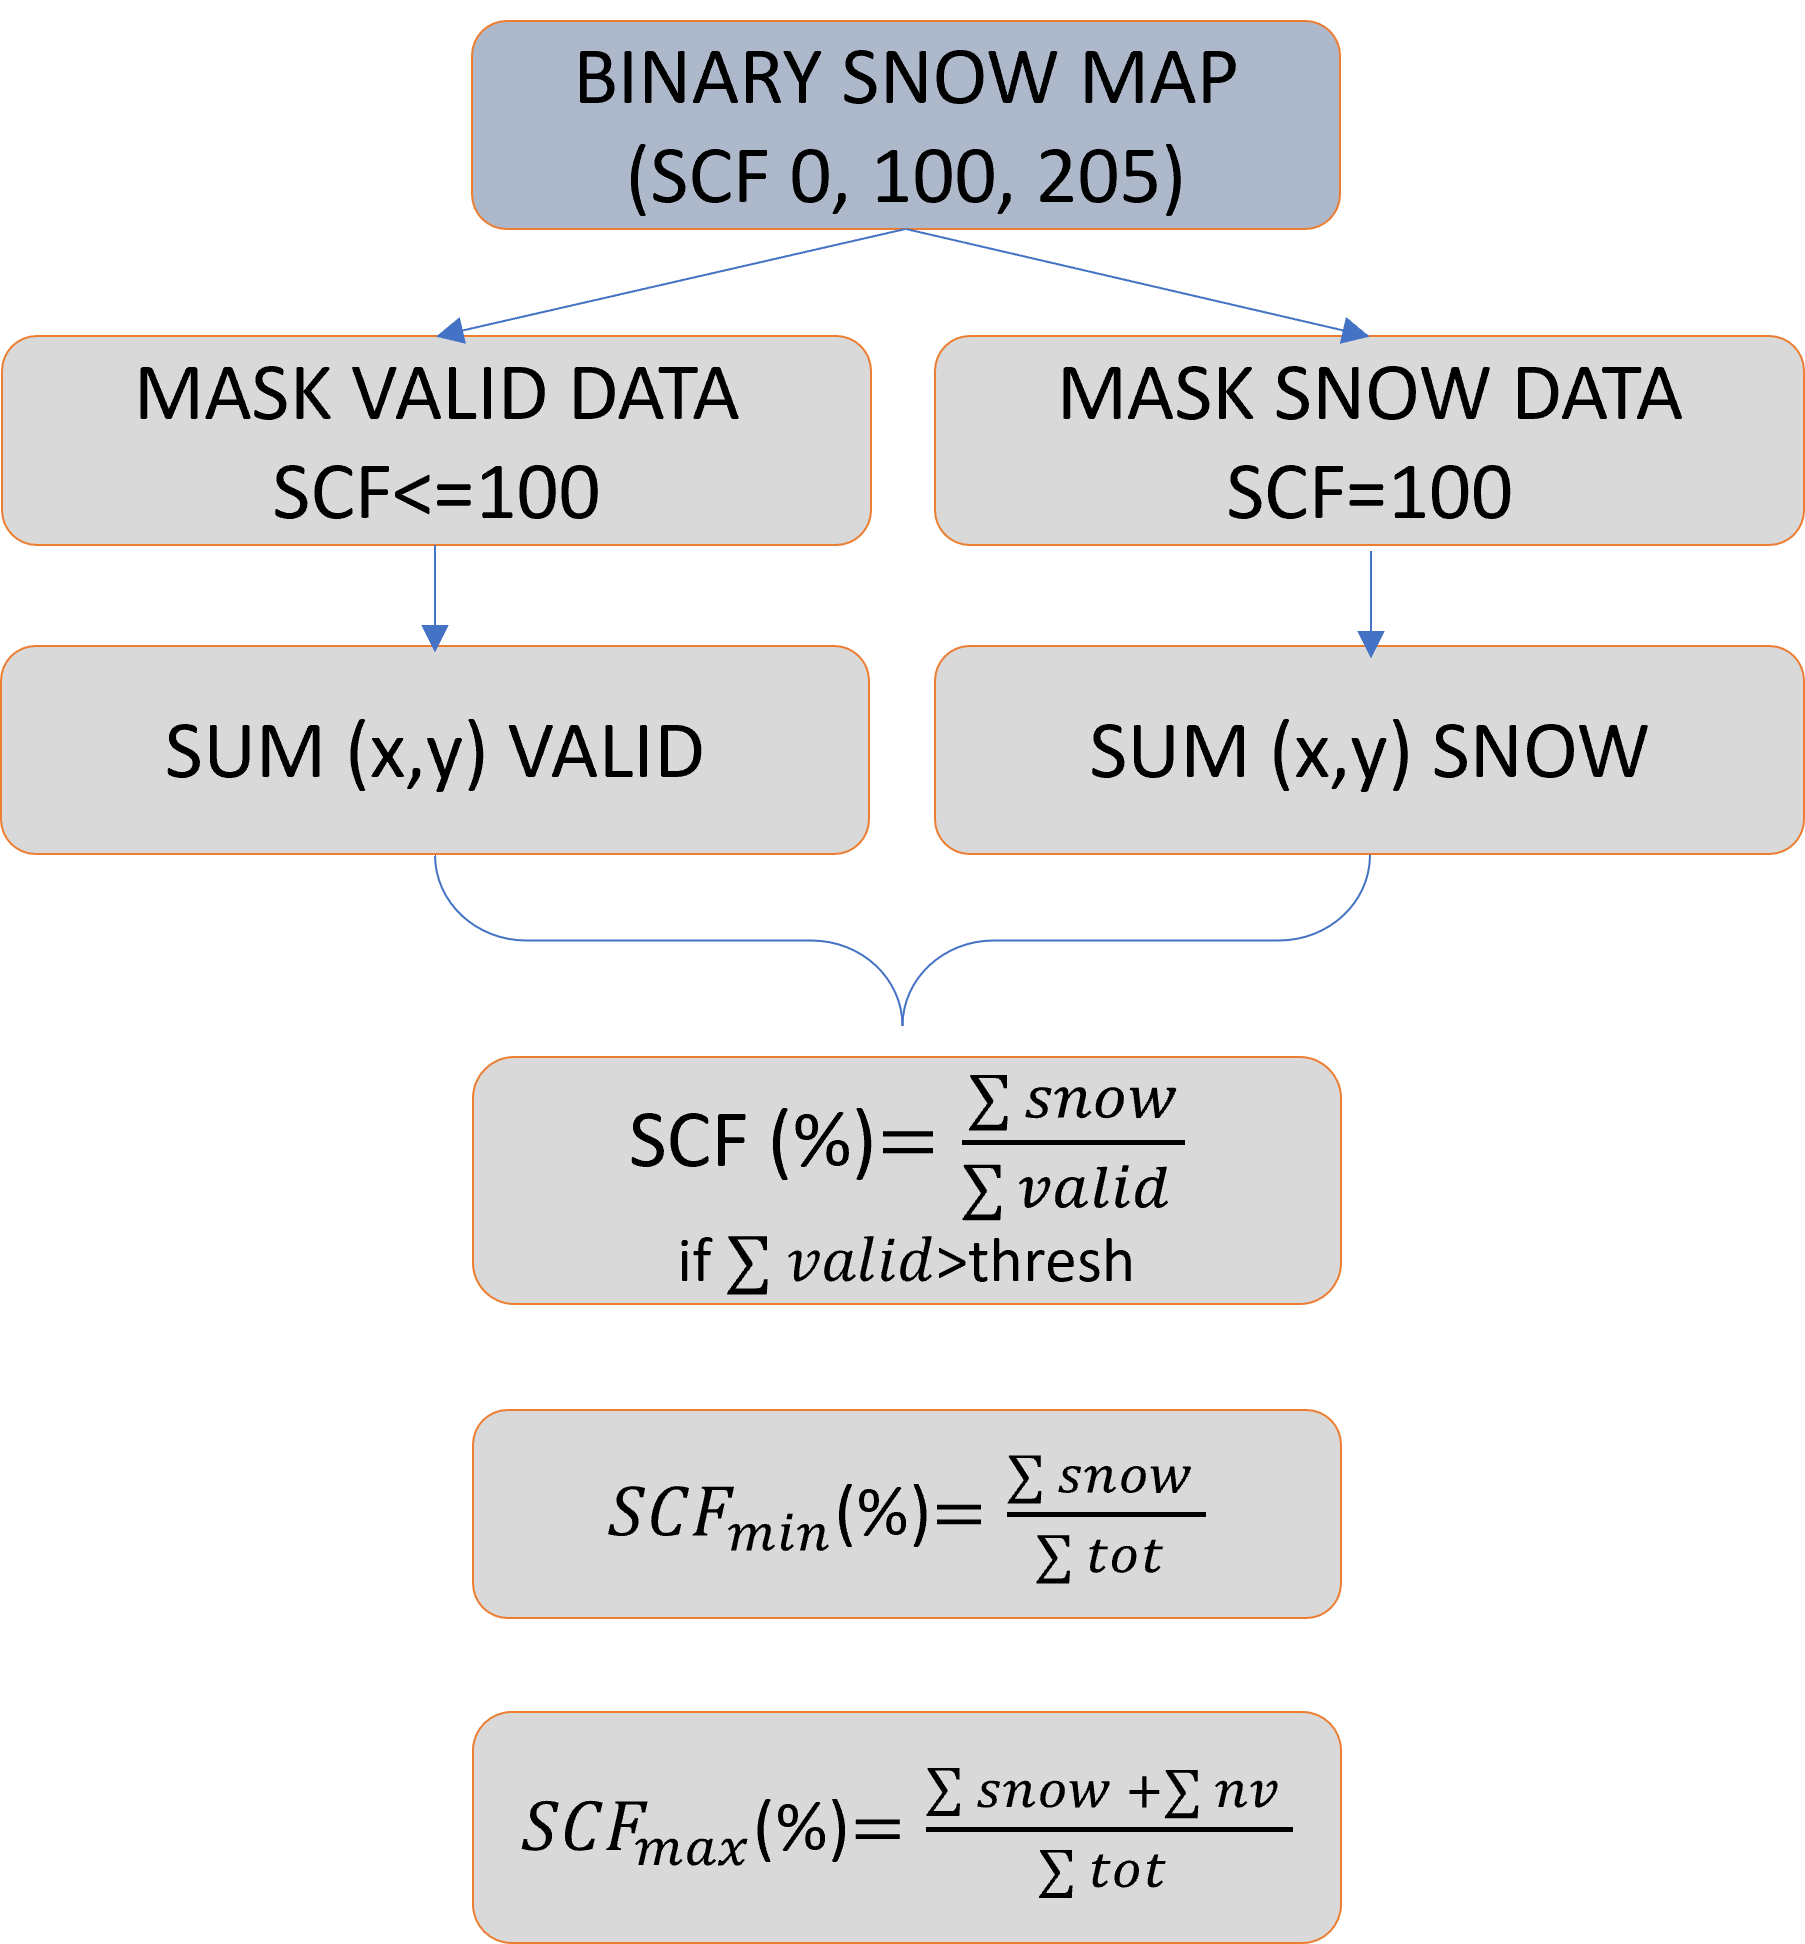
</div>


## Create mask of valid and snow data

In [18]:
# snow (100) and snow free(0) represent the valid pixels
mask_valid = (cube <= 100 )*1.0
#mask_valid_xr = mask_valid.execute()

# Create mask of snow data
mask_snow = (cube == 100 )*1.0
#mask_snow_xr = mask_snow.execute(mask_snow_xr = mask_snow.execute(#)
#mask_valid.download('./results/mask_valid2.nc')

## Sum up the pixels and get SCF LR

In [24]:
# Sum valid data over a LR window
valid_average = mask_valid.resample_cube_spatial(modis, method="average")
valid_sum_lr = valid_average.multiply(pixel_ratio**2)

# Sum the snow pixels
snow_average = mask_snow.resample_cube_spatial(modis, method="average")
snow_sum_lr = snow_average.multiply(pixel_ratio**2)

# Divide by number of valid pixels in the window and get percentage
scf_lr = (snow_sum_lr).divide(valid_sum_lr) #.multiply(100)

scf_lr.download('./results/scf_lr2.nc')


/home/vpremier/.local/lib/python3.10/site-packages/odc/geo/_xr_interop.py:544: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
/home/vpremier/.local/lib/python3.10/site-packages/odc/geo/_xr_interop.py:544: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
/home/vpremier/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


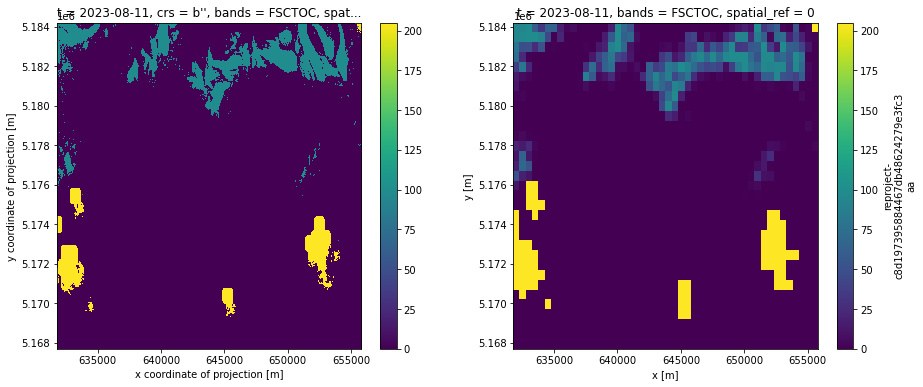

In [11]:




# Replace pixels with non valid data < threshold with 205
valid_threshold = (1-nv_thres/100)*pixel_ratio**2
scf_lr = scf_lr.mask(valid_sum_lr<=valid_threshold , replacement=nv_value)
scf_lr = scf_lr.mask(is_valid(scf_lr).apply(process='not') , replacement=nv_value)

scf_lr_xr = scf_lr.execute()
fig, axs = plt.subplots(1,2, figsize=(15,6))
cube_xr[0,1].plot.imshow(ax=axs[0])
scf_lr_xr[0,1].plot.imshow(ax=axs[1])

### SCF min and max are not used here (but will be used in another step of the workflow..)

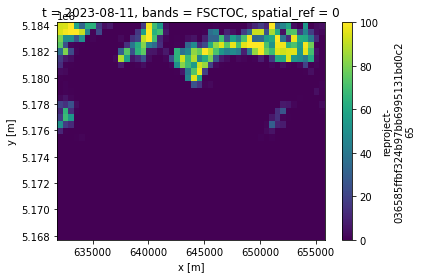

In [12]:
# Compute the minimum SCF (SCF that you would obtain if the non valid pixels are replaced with 0-snow free)
scf_min = (snow_sum_lr / pixel_ratio**2)*100

scf_min_xr = scf_min.execute()
scf_min_xr[0,1].plot.imshow()

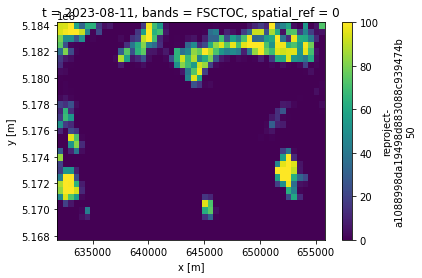

In [13]:
# Compute the maximum SCF (SCF that you would obtain if the non valid pixels are replaced with 100-snow)
scf_max = ((snow_sum_lr + pixel_ratio**2-valid_sum_lr)/ pixel_ratio**2)*100

scf_max_xr = scf_max.execute()
scf_max_xr[0,1].plot.imshow()

### Conditional Probabibilities (CP) computation
Now we pre-compute the CP for user defined SCF ranges. The CP are saved as static maps and will be used later in the downscaling process when reading a LR maps to be downscaled. 

The CP is calculated as sum of the pixels equal to snow over time when it occurs that the associated LR pixel has a SCF within a specific range, divided by the number of occurences.

<div>
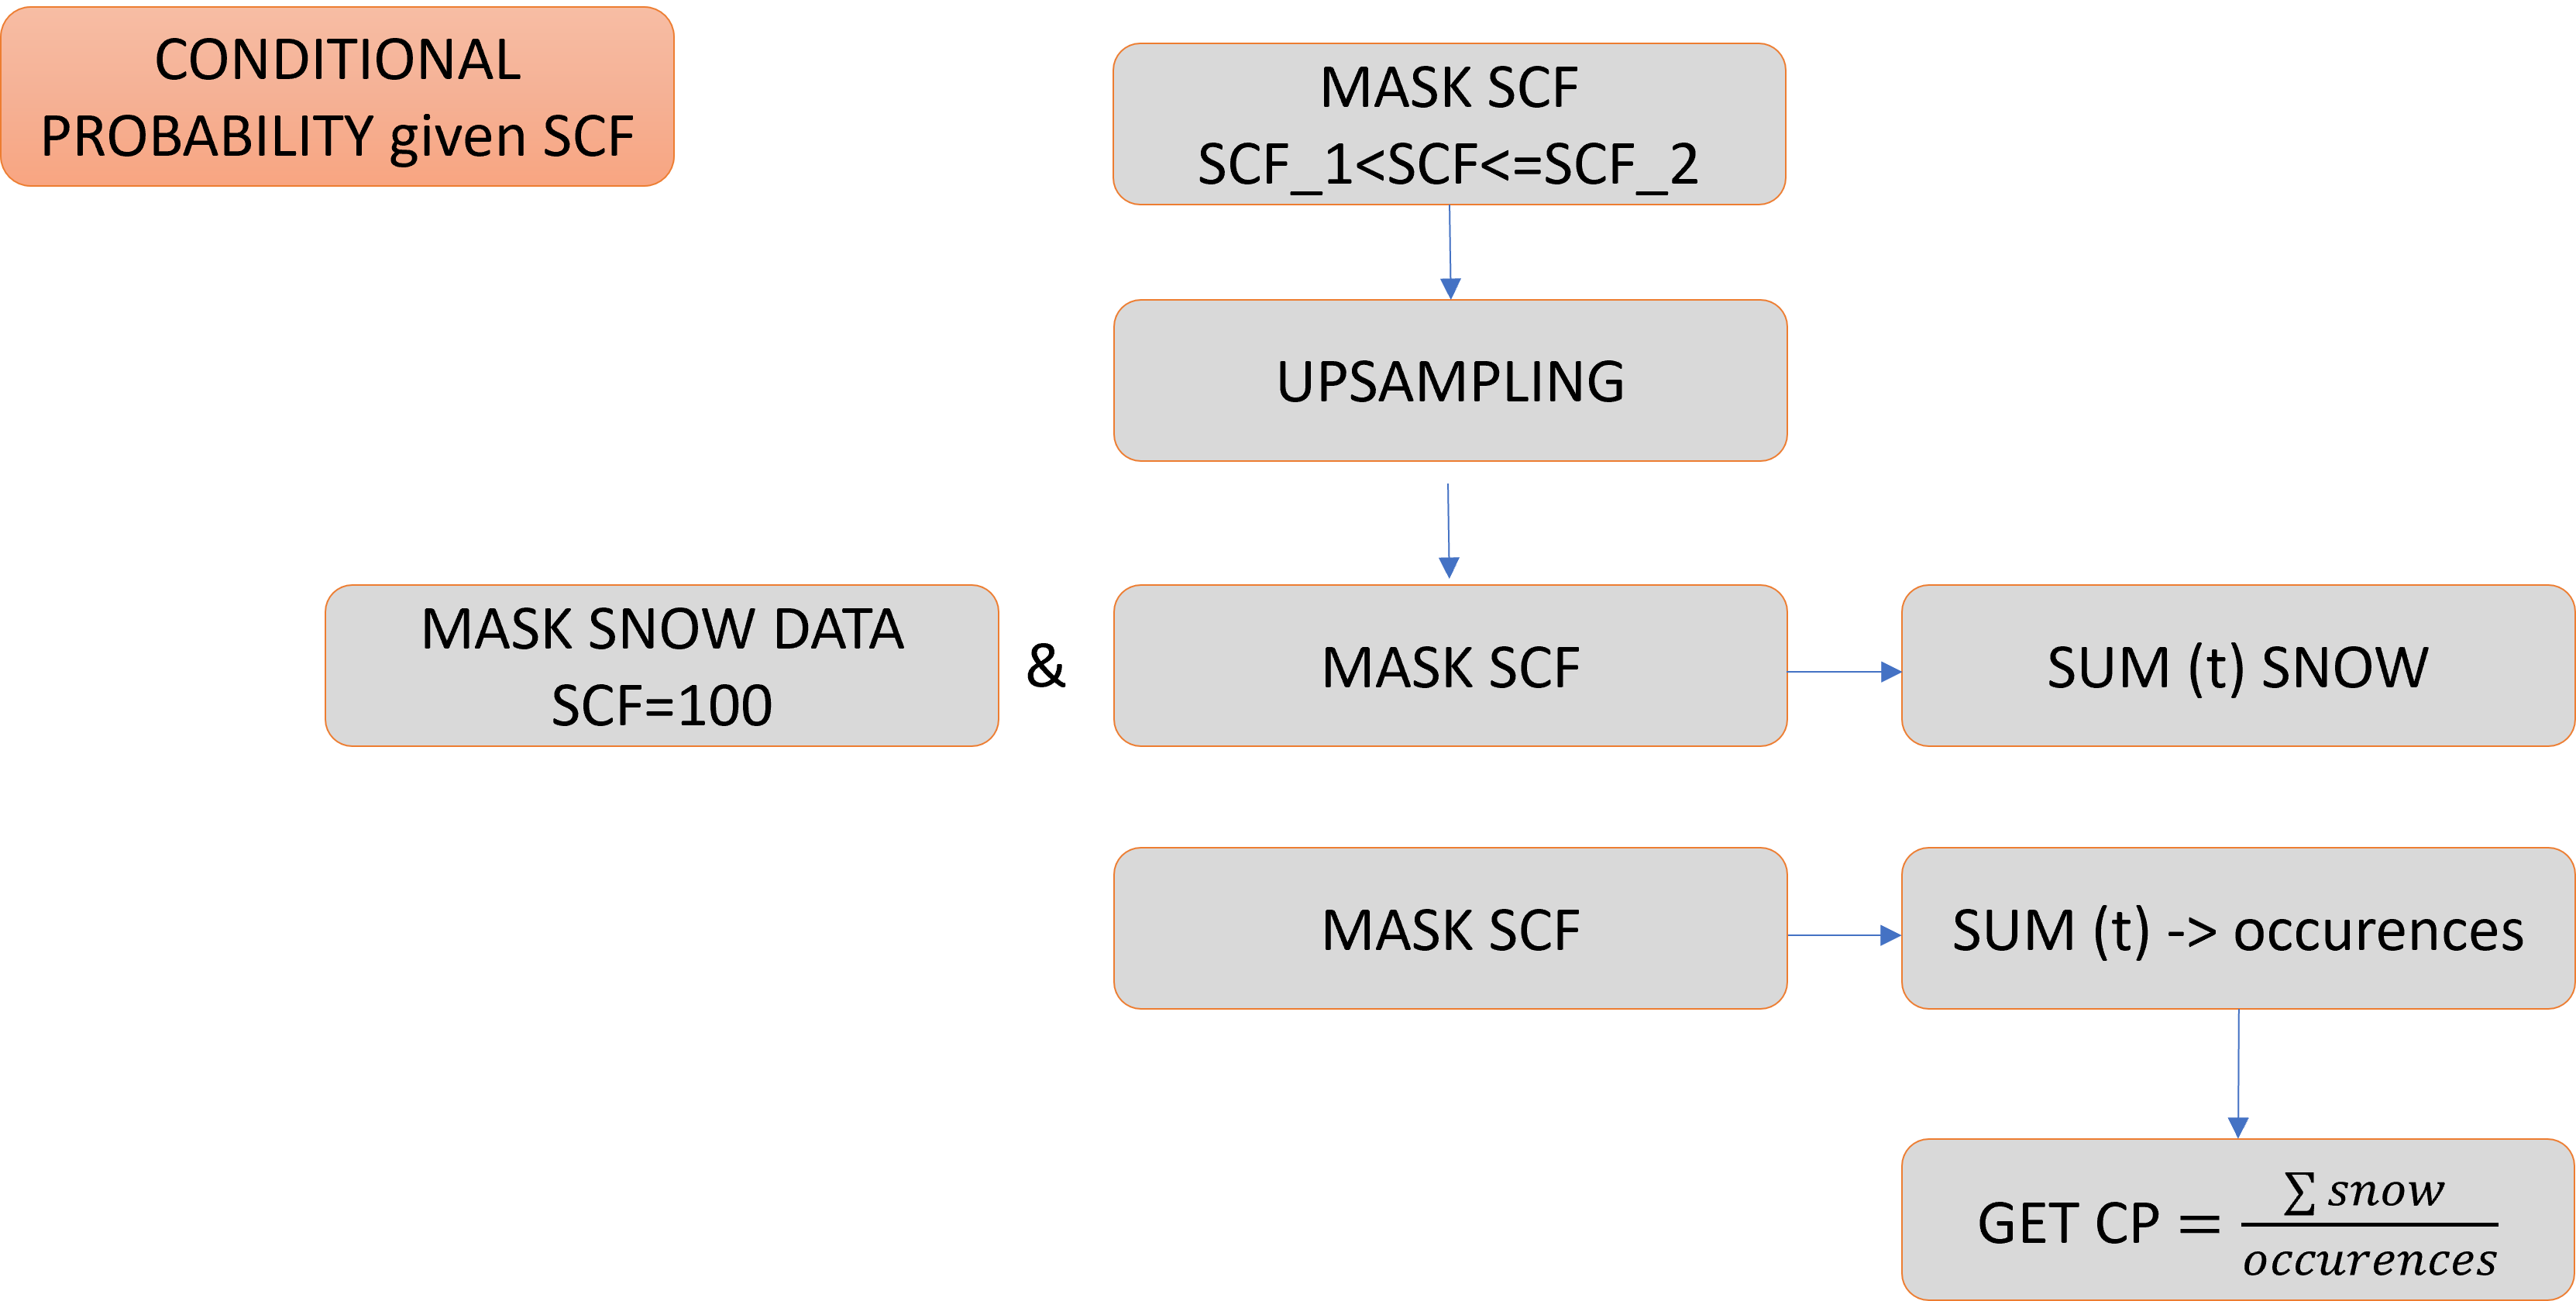
</div>



In [9]:
# Create dictionary with the SCF ranges   
scf_dic = get_scf_ranges(delta, epsilon)
scf_dic

{'0_20': (0, 10),
 '0_30': (10, 20),
 '10_40': (20, 30),
 '20_50': (30, 40),
 '30_60': (40, 50),
 '40_70': (50, 60),
 '50_80': (60, 70),
 '60_90': (70, 80),
 '70_100': (80, 90),
 '80_100': (90, 100)}

In [10]:
# Loop for different snow cover fraction ranges
for i, key in enumerate(scf_dic):
    # range with a buffer - to be considered for the CP computation
    scf_1 = int(key.split('_')[0])
    scf_2 = int(key.split('_')[1])
    print(f'Computing CP by considering {scf_1}<SCF<={scf_2}')
    
    # define the mask scf_1 < scf <= scf_2
    mask_scf_1 =  scf_lr > scf_1
    mask_scf_2 = scf_lr <= scf_2
    mask_scf = mask_scf_1 & mask_scf_2
    
    # upsample again to HR
    mask_scf_hr = mask_scf.resample_cube_spatial(cube)
    
    # add mask with the snow pixels 
    mask_cp_snow = mask_scf_hr.merge_cubes(mask_snow, overlap_resolver="and")
    
    # sum of all the snow pixels over time
    sum_cp_snow = mask_cp_snow.reduce_dimension(reducer="sum", 
                                                dimension="t")
    # mask of all the scf occurences over time
    occurences = mask_scf_hr.reduce_dimension(reducer="sum", 
                                                dimension="t")
    # conditional probabilities
    cp = sum_cp_snow/occurences
    
    # range to be used when performing the downscaling
    label_cp = 'cp_' + str(scf_dic[key][0]) + '_' + str(scf_dic[key][1])
    label_occur = label_cp.replace('cp','occur')
    
    # save information
    cp_renamed = cp.drop_dimension("bands").add_dimension(type="bands",name="bands",label=label_cp)
    occur_renamed = occurences.drop_dimension("bands").add_dimension(type="bands",name="bands",label=label_occur)

    if i==0:
        cp_stac = cp_renamed
        occur_stac = occur_renamed
    else:
        cp_stac = cp_stac.merge_cubes(cp_renamed)
        occur_stac = occur_stac.merge_cubes(occur_renamed)


Computing CP by considering 0<SCF<=20
Computing CP by considering 0<SCF<=30
Computing CP by considering 10<SCF<=40
Computing CP by considering 20<SCF<=50
Computing CP by considering 30<SCF<=60
Computing CP by considering 40<SCF<=70
Computing CP by considering 50<SCF<=80
Computing CP by considering 60<SCF<=90
Computing CP by considering 70<SCF<=100
Computing CP by considering 80<SCF<=100


In [11]:
cp_xr = cp_stac.execute()
occur_xr = occur_stac.execute()

In [15]:
cp_xr.attrs = {}

In [16]:
cp_xr.to_dataset(dim="bands").to_netcdf("/home/vpremier/OEMC/SCA/daily_sca_reconstruction/results/cp_test.nc")

/home/vpremier/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/vpremier/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/vpremier/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [ ]:
occur_xr.to_dataset(dim="bands").to_netcdf("/home/vpremier/OEMC/SCA/daily_sca_reconstruction/results/occur_test.nc")

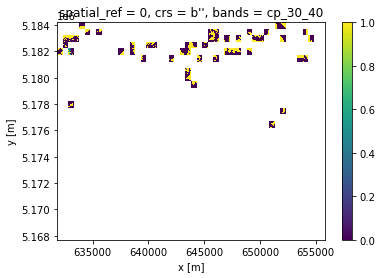

In [70]:
cp_xr[3].plot.imshow()

To do list:
- provare a lanciare per time frame più lungo
- fare downscaling dal dato MODIS